In [ ]:
import ast
import math
import torch
import torchvision
import pickle as pkl
import pandas as pd
import numpy as np
import seaborn as sns
from einops import rearrange
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from adjustText import adjust_text
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

In [ ]:
with open(
    "../model=slow-50-tap/model=slow-50_method=tap-16x8-w-negatives_ext=sw-0.5_return-feats=train_feats.pkl",
    "rb",
) as f:
    data = pkl.load(f)

metadata = pd.read_csv(
    "/home/dl18206/Desktop/phd/data/panaf/PanAfFull/notebooks/data/panaf-seq_metadata.csv"
)

In [43]:
with open(
    "../model=slow-50-tap/model=slow_r50-w-negatives_type=return_train_feats_feats.pkl",
    "rb",
) as f:
    g_data = pkl.load(f)

with open("../data/behaviours.txt", "rb") as f:
    behaviours = [beh.decode("utf-8").strip() for beh in f.readlines()]

In [ ]:
subclips = []
for name, feat, cls_act_seq, global_feat, global_pred in zip(
    data["names"], data["feats"], data["cas"], g_data["feats"], g_data["preds"]
):
    recon_mean = []
    for i, (f, c) in enumerate(zip(feat, cls_act_seq)):
        subclips.append(
            {
                "name": name,
                "feat": f.detach().cpu().numpy(),
                "cas": c.detach().cpu().numpy(),
                "timestep": i,
                "point_type": "local",
            }
        )
        if i == 0:
            recon_mean.append(f.detach().cpu().numpy())
        else:
            recon_mean.append(f.detach().cpu().numpy())

    subclips.append(
        {
            "name": name,
            "feat": global_feat.detach().cpu().numpy(),
            "cas": global_pred.detach().cpu().numpy(),
            "timestep": i + 1,
            "point_type": "global",
        }
    )
    subclips.append(
        {
            "name": name,
            "feat": np.mean(recon_mean, axis=0),
            "cas": global_pred.detach().cpu().numpy(),
            "timestep": i + 2,
            "point_type": "reconstructed",
        }
    )
df = pd.DataFrame(subclips, columns=["name", "feat", "cas", "timestep", "point_type"])
df = df.merge(metadata, how="left", left_on="name", right_on="subject_id")

In [ ]:
df["softmax"] = df.cas.apply(lambda x: torch.softmax(torch.tensor(x), dim=0))
df["topk_cls_idx"] = df.softmax.apply(lambda x: torch.topk(x, 3).indices.numpy())
df["topk_cls_val"] = df.softmax.apply(lambda x: torch.topk(x, 3).values.numpy())

# Round the cls values to 2 decimal places
df["topk_cls_val"] = df["topk_cls_val"].apply(lambda x: [round(i, 2) for i in x])

In [ ]:
# Perform t-SNE on the features and add x1 and x2 columns to the dataframe
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

tsne_results = tsne.fit_transform(df["feat"].tolist())
df["x1"] = tsne_results[:, 0]
df["x2"] = tsne_results[:, 1]

In [ ]:
def filter_behaviours(x, tgt_b):
    gt_seq = x.split(",")
    for i in gt_seq:
        if i in tgt_b:
            return True
    return False


def plot_tsne_results(
    df,
    colour_by=["name"],
    annotate_by="timestep",
    batch_size=320,
    fig_size=(5, 3),
    save_name=False,
    behaviours=None,
    exact_match=False,
    videos=None,
    show_global=False,
):
    """
    Plot t-SNE results for subclip embeddings.

    Args:
        df (DataFrame): The DataFrame containing the subclip embeddings.
        colour_by (str or list, optional): The column(s) to use for coloring the scatter plot(s). Defaults to ["name"].
        annotate_by (str, optional): The column to use for annotating the scatter plot. Defaults to "timestep".
        batch_size (int, optional): The number of data points to include in the scatter plot. Defaults to 320.
        fig_size (tuple, optional): The size of the figure. Defaults to (10, 6).
        save_name (bool or str, optional): If True, the plot will be saved with the specified name.
            If False, the plot will not be saved. If a string is provided, the plot will be saved with the specified name.
            Defaults to False.
        behaviours (list, optional): The list of behaviors to filter the data by. Defaults to None.
        exact_match (bool, optional): If True, only subclip embeddings with behaviors exactly matching the provided list will be included in the plot.
            If False, subclip embeddings with behaviors containing any of the provided list will be included in the plot.
            Defaults to False.
        videos (list, optional): The list of videos to filter the data by. Defaults to None.
        name (str, optional): The name variable for the plot. Defaults to None.
        show_global (bool, optional): If True, global subclip embeddings will be included in the plot.
            If False, only local subclip embeddings will be included in the plot. Defaults to False.

    Returns:
        None
    """
    # Convert colour_by to list if it's a string
    if isinstance(colour_by, str):
        colour_by = [colour_by]

    # Calculate the number of rows and columns for subplots
    n_plots = len(colour_by)
    n_cols = min(3, n_plots)  # Maximum 3 columns
    n_rows = (n_plots - 1) // n_cols + 1

    # Create a figure with subplots
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(fig_size[0] * n_cols, fig_size[1] * n_rows)
    )
    if n_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # Filter by behaviours(s)
    if behaviours is not None:
        if exact_match:
            df = df[df.value.apply(lambda x: set(behaviours) == set(x.split(",")))]
        else:
            df = df[df.value.apply(lambda x: filter_behaviours(x, behaviours))]

    # Filter by video(s)
    if videos is not None:
        df = df[df.name.isin(videos)]

    # Remove plot_type if == "global"
    if not show_global:
        df = df[df.point_type == "local"]

    # Create scatter plots for each colour_by variable
    for i, col in enumerate(colour_by):
        ax = axes[i]
        scatter = sns.scatterplot(
            x="x1",
            y="x2",
            hue=col,
            data=df.head(batch_size),
            legend="full",
            alpha=1.0,
            ax=ax,
        )

        # Prepare annotations
        if annotate_by is not None:
            texts = []
            for idx, row in df.head(batch_size).iterrows():
                texts.append(
                    ax.text(
                        row["x1"],
                        row["x2"],
                        str(row[annotate_by].values[0]),
                        fontsize=8,
                        alpha=0.7,
                    )
                )

            # Adjust text positions to prevent overlap
            adjust_text(
                texts,
                arrowprops=dict(arrowstyle="->", color="red", lw=0.5),
                expand_points=(1.2, 1.2),
                force_points=(0.1, 0.25),
                ax=ax,
            )

        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, ncol=1)

        if behaviours is not None:
            behaviours = (
                behaviours[0] if len(behaviours) == 1 else ", ".join(behaviours)
            )
        else:
            behaviours = "random"

        ax.set_title(
            f"Subclips: 16, Frames: 8, Behaviours: {behaviours}, Colored by: {col}"
        )

    # Remove any unused subplots
    for i in range(n_plots, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()

    if save_name:
        plt.savefig(f"{save_name}.pdf", dpi=300, bbox_inches="tight")

    plt.show()

In [ ]:
# def return_video_names(df, classes, exact_match, batch_size):
#     # Filter by behaviours(s)
#     if behaviours is not None:
#         if exact_match:
#             df = df[df.value.apply(lambda x: set(classes) == set(x.split(",")))]
#         else:
#             df = df[df.value.apply(lambda x: filter_behaviours(x, classes))]
#     return df.head(batch_size)["name"].unique()


# classes = ["display", "aggression", "piloerection"]

# video_names_iter = return_video_names(df, classes, False, 640)
# video_names_iter

In [71]:
global_df = df[df.point_type == "global"]
global_df["label"] = global_df["label"].apply(lambda x: ast.literal_eval(x))

cls_feat = []
sample_feat = []

for idx in range(len(behaviours)):
    features = []
    purities = []
    tmp_df = global_df[global_df.label.apply(lambda x: x[idx] == 1)]
    for row in tmp_df.iterrows():
        feature = row[1]["feat"]
        purity = 1 / sum(row[1]["label"])
        features.append(feature)
        purities.append(purity)
    cls_feat.append(np.average(features, axis=0, weights=purities))

<ipython-input-71-a765feaed23d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_df['label'] = global_df['label'].apply(lambda x: ast.literal_eval(x))


In [ ]:
global_df.label.apply(lambda x: x[idx] == 1)

(14, 2048)

In [75]:
# Perform t-SNE on the features and add x1 and x2 columns to the dataframe
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(np.stack(cls_feat))

/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 14 samples in 0.001s...
[t-SNE] Computed neighbors for 14 samples in 0.307s...
[t-SNE] Computed conditional probabilities for sample 14 / 14
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 101.664566
[t-SNE] KL divergence after 300 iterations: 0.551155


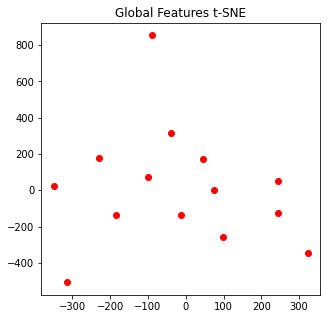

In [76]:
# Plot the t-SNE results
plt.figure(figsize=(5, 5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c="r")
plt.title("Global Features t-SNE")
plt.show()

In [ ]:
plot_tsne_results(
    df,
    colour_by=["name", "point_type"],
    annotate_by=None,  # ["topk_cls_idx"],
    batch_size=1000,
    fig_size=(10, 6),
    # behaviours=classes,
    exact_match=False,
    show_global=True,
    videos=["acp000bhwx.mp4", "acp0005a6i.mp4", "acp0005a9y.mp4", "acp000dkt6.mp4"],
)

In [ ]:
plot_tsne_results(
    df,
    colour_by=["name"],
    annotate_by=None,  # ["topk_cls_idx"],
    batch_size=48,
    fig_size=(10, 6),
    behaviours=classes,
    exact_match=False,
    show_global=False,
    videos=["acp000b8ft.mp4", "acp000c7n9.mp4", "acp0005a6g.mp4"],
)

In [41]:
dict(enumerate(behaviours))

NameError: name 'behaviours' is not defined

In [ ]:
def video_to_clips(
    video_tensor, n_clips, n_samples, overlap=0.25, sliding_window=False
):
    """
    Converts a video tensor into a list of clips.

    Args:
        video_tensor (torch.Tensor): The input video tensor of shape (T, C, H, W), where T is the number of frames,
                                     C is the number of channels, H is the height, and W is the width.
        n_clips (int): The desired number of clips to generate.
        n_samples (int): The number of samples to subsample from each clip.
        overlap (float, optional): The overlap ratio between adjacent clips. Defaults to 0.25.
        sliding_window (bool, optional): If True, uses a sliding window approach to generate clips. If False,
                                         divides the video tensor into equal-sized clips.

    Returns:
        list: A list of clips, where each clip is a tensor of shape (T_clip, C, H, W), and T_clip is the number of frames
              in each clip.
    """
    clips = []
    T, C, H, W = video_tensor.shape
    if sliding_window:
        # Calculate the size of each clip
        clip_size = math.ceil(T / (n_clips * (1 - overlap) + overlap))

        # Calculate stride based on the overlap
        stride = math.floor(clip_size * (1 - overlap))

        start = 0
        while start + clip_size <= T:
            clip = video_tensor[start : start + clip_size]
            ss_clip = subsample_clip(clip, n_samples)
            clips.append(ss_clip)
            start += stride

        # If we haven't generated enough clips, add the last clip
        if len(clips) < n_clips:
            start = T - clip_size
            clip = video_tensor[start:T]
            ss_clip = subsample_clip(clip, n_samples)
            clips.append(ss_clip)

        # If we have generated too many clips, keep the first n_clips
        clips = clips[:n_clips]
    else:
        T_per_clip = T // n_clips
        for i in range(n_clips):
            ss_clip = subsample_clip(
                video_tensor[i * T_per_clip : (i + 1) * T_per_clip], n_samples
            )
            clips.append(ss_clip)
    return clips


def subsample_clip(clip, n_samples):
    T, C, H, W = clip.shape
    if T <= n_samples:
        return clip

    indices = torch.linspace(0, T - 1, n_samples).long()
    return clip[indices]


def visualize_logits_and_labels(
    logits, global_logits, labels, behaviours, class_seq, video_name
):
    """
    Visualize subclip logits, global logits, and multi-hot encoded labels side by side.

    Parameters:
    logits (np.array): Array of shape [n_clips, num_classes] containing logits
    global_logits (np.array): Array of shape [1, num_classes] containing global logits
    labels (np.array): Array of shape [1, num_classes] containing multi-hot encoded labels
    behaviours (list): List of behaviour labels for y-axis
    class_seq (str): Title for the logits subplot

    Returns:
    fig (matplotlib.figure.Figure): The created figure
    """
    # Apply sigmoid function to logits and global logits
    sigmoid_logits = 1 / (1 + np.exp(-logits))
    sigmoid_global_logits = 1 / (1 + np.exp(-global_logits))

    # Create a custom colormap that goes from white to blue
    colors = [(1, 1, 1), (0, 0, 1)]  # White to Blue
    n_bins = 100  # Number of color gradations
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)

    # Create a figure with a custom grid
    fig = plt.figure(figsize=(24, 8))
    gs = GridSpec(1, 4, figure=fig, width_ratios=[8, 1, 1, 0.2])

    # Subfigure 1: Sigmoid-activated logits
    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(sigmoid_logits.T, aspect="auto", cmap=cmap, vmin=0, vmax=1)
    ax1.set_xlabel("Subclips")
    ax1.set_ylabel("Classes")
    ax1.set_title(f"{video_name}: {class_seq}")

    # Add text annotations for sigmoid logits
    for i in range(sigmoid_logits.shape[1]):
        for j in range(sigmoid_logits.shape[0]):
            ax1.text(
                j,
                i,
                f"{sigmoid_logits[j, i]:.2f}",
                ha="center",
                va="center",
                color="black",
                fontsize=10,
            )

    # Subfigure 2: Global logits
    ax2 = fig.add_subplot(gs[0, 1])
    im2 = ax2.imshow(sigmoid_global_logits.T, aspect="auto", cmap=cmap, vmin=0, vmax=1)
    ax2.set_title("Global Logits")

    # Add text annotations for global logits
    for i in range(sigmoid_global_logits.shape[1]):
        ax2.text(
            0,
            i,
            f"{sigmoid_global_logits[0, i]:.2f}",
            ha="center",
            va="center",
            color="black",
            fontsize=10,
        )

    # Subfigure 3: Multi-hot encoded labels
    ax3 = fig.add_subplot(gs[0, 2])
    im3 = ax3.imshow(labels.T, aspect="auto", cmap=cmap, vmin=0, vmax=1)
    ax3.set_title("Multi-hot Encoded Label")

    # Add text annotations for labels
    for i in range(labels.shape[1]):
        ax3.text(
            0,
            i,
            str(int(labels[0, i])),
            ha="center",
            va="center",
            color="black",
            fontsize=10,
        )

    # Set ticks for subfigures
    ax1.set_xticks(np.arange(0, sigmoid_logits.shape[0]))
    ax1.set_xticklabels(np.arange(0, sigmoid_logits.shape[0]))
    ax1.set_yticks(np.arange(sigmoid_logits.shape[1]))
    ax1.set_yticklabels(behaviours)

    for ax in [ax2, ax3]:
        ax.set_xticks([])  # Remove x-ticks
        ax.set_xticklabels([])  # Remove x-tick labels
        ax.set_yticks(np.arange(labels.shape[1]))
        ax.set_yticklabels([])  # Remove y-tick labels

    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add a single colorbar to the right of the labels subplot
    cax = fig.add_subplot(gs[0, 3])
    cbar = fig.colorbar(im1, cax=cax)
    cbar.set_label("Activation Strength / Label Presence")

    # Adjust layout
    plt.tight_layout()
    plt.show()


def plot_video(video_name, n_clips, n_samples, sliding_window=False):

    path2video = f"/home/dl18206/Desktop/phd/data/panaf/acp/videos/all/{video_name}"

    video = torchvision.io.read_video(path2video, pts_unit="sec")[0]

    clips = video_to_clips(video, n_clips, n_samples, sliding_window=sliding_window)
    clips = rearrange(torch.stack(clips), "n t h w c -> (n t) c h w")

    grid = make_grid(clips, nrow=n_samples)
    img = torchvision.transforms.ToPILImage()(grid)
    img.show()

In [ ]:
def extract_info(df, vid):
    class_act_seq = df[df.name == vid]["cas"].values
    class_act_seq = np.vstack(class_act_seq)

    global_logits = df[(df.name == vid) & (df.timestep == 16)]["cas"].values[0]
    global_logits = global_logits.reshape(1, -1)

    labels = df[df.name == vid]["label"].values[0]
    labels = ast.literal_eval(labels)
    labels = np.array(labels).reshape(1, -1)

    class_seq = df[df.name == vid]["value"].values[0]
    class_seq = class_seq.replace(",", " -> ")

    return class_act_seq[:-1,], global_logits, labels, class_seq


def plot_tsne_results_subplot(
    ax,
    df,
    colour_by,
    annotate_by,
    video_name,
    batch_size,
    only_behaviours=None,
    exact_match=False,
    show_global=False,
):
    """
    Plot t-SNE results on a given subplot.
    """
    # Filter by behaviours(s)
    if only_behaviours is not None:
        if exact_match:
            df = df[df.value.apply(lambda x: set(only_behaviours) == set(x.split(",")))]
        else:
            df = df[df.value.apply(lambda x: filter_behaviours(x, only_behaviours))]

    # Filter by video_name
    df = df[df.name.isin([video_name])]

    if not show_global:
        df = df[df.point_type == "local"]

    scatter = sns.scatterplot(
        x="x1",
        y="x2",
        hue=colour_by,
        data=df.head(batch_size),
        legend="full",
        alpha=1.0,
        ax=ax,
    )

    if annotate_by is not None:
        texts = []
        for idx, row in df.head(batch_size).iterrows():
            texts.append(
                ax.text(
                    row["x1"], row["x2"], str(row[annotate_by]), fontsize=6, alpha=0.7
                )
            )

        adjust_text(
            texts,
            arrowprops=dict(arrowstyle="->", color="red", lw=0.5),
            expand_points=(1.2, 1.2),
            force_points=(0.1, 0.25),
        )

    ax.legend(
        bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, ncol=1, fontsize="x-small"
    )
    ax.set_title(f"t-SNE: Subclip embs coloured by {colour_by}")


def visualize_logits_labels_video_and_tsne(
    df,
    video_name,
    behaviours,
    n_clips,
    n_samples,
    exact_match=False,
    save_prefix=None,
    sliding_window=False,
    colour_by="name",
    annotate_by="timestep",
    batch_size=160,
    show_global=False,
    video_frame_width=3,  # New parameter for video frame width
):
    """
    Visualize subclip logits, global logits, multi-hot encoded labels, video frames, and t-SNE plot side-by-side.

    Parameters:
    df (DataFrame): The DataFrame containing the data for visualization
    video_name (str): Name of the video
    behaviours (list): List of behaviour labels for y-axis
    n_clips (int): Number of clips
    n_samples (int): Number of samples per clip
    sliding_window (bool): Whether to use sliding window for clip generation
    colour_by (str): Column to use for coloring the t-SNE plot
    annotate_by (str): Column to use for annotating the t-SNE plot
    batch_size (int): Number of data points to include in the t-SNE plot
    show_global (bool): Whether to show global embeddings in the t-SNE plot
    video_frame_width (float): Width ratio for the video frames subplot

    Returns:
    fig (matplotlib.figure.Figure): The created figure
    """
    path2video = f"/home/dl18206/Desktop/phd/data/panaf/acp/videos/all/{video_name}"
    video_tensor = torchvision.io.read_video(path2video, pts_unit="sec")[0]

    logits, global_logits, labels, class_seq = extract_info(df, video_name)

    # Apply sigmoid function to logits and global logits
    sigmoid_logits = 1 / (1 + np.exp(-logits))
    sigmoid_global_logits = 1 / (1 + np.exp(-global_logits))

    # Create a custom colormap that goes from white to blue
    colors = [(1, 1, 1), (0, 0, 1)]  # White to Blue
    n_bins = 100  # Number of color gradations
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)

    # Calculate width ratios based on the video_frame_width
    width_ratios = [6, 1, 1, 0.4, video_frame_width, 3]
    total_width = sum(width_ratios)
    width_ratios = [
        w / total_width * 30 for w in width_ratios
    ]  # Scale to 30 total width

    # Create a figure with a custom grid
    fig = plt.figure(figsize=(30, 8))
    gs = GridSpec(1, 6, figure=fig, width_ratios=width_ratios)

    # Subfigure 1: Sigmoid-activated logits
    ax1 = fig.add_subplot(gs[0])
    im1 = ax1.imshow(sigmoid_logits.T, aspect="auto", cmap=cmap, vmin=0, vmax=1)
    ax1.set_xlabel("Subclips")
    ax1.set_ylabel("Classes")
    ax1.set_title(f"{video_name}: {class_seq}")

    # Add text annotations for sigmoid logits
    for i in range(sigmoid_logits.shape[1]):
        for j in range(sigmoid_logits.shape[0]):
            ax1.text(
                j,
                i,
                f"{sigmoid_logits[j, i]:.2f}",
                ha="center",
                va="center",
                color="black",
                fontsize=6,
            )

    # Subfigure 2: Global logits
    ax2 = fig.add_subplot(gs[1])
    im2 = ax2.imshow(sigmoid_global_logits.T, aspect="auto", cmap=cmap, vmin=0, vmax=1)
    ax2.set_title("Global Logits")

    # Add text annotations for global logits
    for i in range(sigmoid_global_logits.shape[1]):
        ax2.text(
            0,
            i,
            f"{sigmoid_global_logits[0, i]:.2f}",
            ha="center",
            va="center",
            color="black",
            fontsize=6,
        )

    # Subfigure 3: Multi-hot encoded labels
    ax3 = fig.add_subplot(gs[2])
    im3 = ax3.imshow(labels.T, aspect="auto", cmap=cmap, vmin=0, vmax=1)
    ax3.set_title("Multi-hot Encoded Label")

    # Add text annotations for labels
    for i in range(labels.shape[1]):
        ax3.text(
            0,
            i,
            str(int(labels[0, i])),
            ha="center",
            va="center",
            color="black",
            fontsize=6,
        )

    # Set ticks for subfigures
    ax1.set_xticks(np.arange(0, sigmoid_logits.shape[0]))
    ax1.set_xticklabels(np.arange(0, sigmoid_logits.shape[0]))
    ax1.set_yticks(np.arange(sigmoid_logits.shape[1]))
    ax1.set_yticklabels(behaviours)

    for ax in [ax2, ax3]:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks(np.arange(labels.shape[1]))
        ax.set_yticklabels([])

    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add a single colorbar
    cax = fig.add_subplot(gs[3])
    cbar = fig.colorbar(im1, cax=cax)
    cbar.set_label("Activation Strength / Label Presence")

    # Subfigure 4: Video frames
    ax4 = fig.add_subplot(gs[4])
    clips = video_to_clips(
        video_tensor, n_clips, n_samples, sliding_window=sliding_window
    )
    clips = rearrange(torch.stack(clips), "n t h w c -> (n t) c h w")
    grid = make_grid(clips, nrow=n_samples)
    ax4.imshow(grid.permute(1, 2, 0))
    ax4.set_title("Video Frames")

    # Add y-ticks to video frames subfigure
    ax4.set_yticks(
        np.linspace(0, grid.shape[1], n_clips + 1)[:-1] + grid.shape[1] / (2 * n_clips)
    )
    ax4.set_yticklabels(range(n_clips))
    ax4.set_ylabel("Clip Number")

    # Subfigure 5: t-SNE plot
    ax5 = fig.add_subplot(gs[5])
    plot_tsne_results_subplot(
        ax5,
        df=df,
        colour_by=colour_by,
        annotate_by=annotate_by,
        video_name=video_name,
        batch_size=batch_size,
        show_global=show_global,
    )

    # Adjust layout
    plt.tight_layout()
    if save_prefix is not None:
        plt.savefig(f"{save_prefix}_v={video_name}.pdf", dpi=300)
    return fig

In [42]:
from tqdm import tqdm

videos = ["acp0000eeb.mp4", "acp0000948.mp4", "acp00000mc.mp4"]

for video_name in tqdm(videos):
    fig = visualize_logits_labels_video_and_tsne(
        df,
        video_name,
        behaviours=behaviours,
        n_clips=16,
        n_samples=4,
        sliding_window=True,
        save_prefix=save_name,
        colour_by="name",
        annotate_by="timestep",
    )

  0%|          | 0/3 [00:00<?, ?it/s]


NameError: name 'visualize_logits_labels_video_and_tsne' is not defined